In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import rioxarray as rio
from glob import glob

# import utils file
import os
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent) + "/code/")
from utils import *

# Test notebook `00e_preprocess_DGVMs`

## 1. Introduction

We test the performance of our approach by calculating the global nbp in S2 simulations and comparing them to the reported values in the GCB data

## 2. Load data

In [20]:
GCB_global_results = pd.read_excel('../data/carbon_cycle/GCB/Global_Carbon_Budget_2023v1.1.xlsx',sheet_name='Terrestrial Sink',skiprows=27,index_col=0)

## 3. Define functions for analysis

In [3]:
def get_area(model:str) -> xr.DataArray:
    """
    Get the area of each pixel for a given model

    Parameters:
    model: str
        the name of the model

    Returns:
    xr.DataArray
        the area of each pixel
    """

    if model == 'CLM5.0':
        
        # if the model is DLEM use the land area file and convert km2 to m2
        area_ds = xr.open_dataset('../data/DGVMs/trendy-v12/CLM5.0_S3_area.nc')
        area = area_ds['area']*area_ds['landfrac']
        
        # rename coordinates to x,y
        area = area.rename({'lat': 'y', 'lon': 'x'})
    elif model == 'DLEM':
        
        # if the model is DLEM use the land area file and convert km2 to m2
        area = xr.open_dataset(f'../data/DGVMs/trendy-v12/DLEM_land_area.nc')['LAND_AREA']*1e6
        area = area.rename({'lat': 'y', 'lon': 'x'})
    elif model in ['IBIS','OCN','ORCHIDEE','LPJmL']:
        
        # load the ocean cover fraction data
        ocean = xr.open_dataset(f'../data/DGVMs/trendy-v12/{model}_S3_oceanCoverFrac.nc',decode_times=False)['oceanCoverFrac']
        
        # rename coordinates to x,y
        ocean = ocean.rename({'latitude': 'y', 'longitude': 'x'})
        
        # the land data is the cell area times the fraction of the cell that is not ocean
        area = calc_pixel_area(ocean)*(1-ocean)
    elif model == 'CLASSIC':
        # load land fraction data
        land_fraction = xr.open_dataset(f'../data/DGVMs/trendy-v12/CLASSIC_S3_land_fraction.nc')['sftlf'].rename({'latitude': 'y', 'longitude': 'x'})
        # the land area is the cell area times the land fraction
        area = calc_pixel_area(land_fraction)*land_fraction
    elif model == 'EDv3':
        area = xr.open_dataset('../data/DGVMs/trendy-v12/EDv3_landCoverFrac.nc')['landArea'].rename({'latitude': 'y', 'longitude': 'x'})
    
    elif model == 'ISBA-CTRIP':
        # load the grid cell area file and rename coordinates
        cell_area = xr.open_dataset(f'../data/DGVMs/trendy-v12/ISBA-CTRIP_area.nc')['AREA'].rename({'LAT_FULL':'y','LON_FULL':'x'})
        
        # load the land area fraction data and rename coordinates
        land_fraction = xr.open_dataset(f'../data/DGVMs/trendy-v12/ISBA-CTRIP_sftlf.nc')['sftlf'].rename({'lat_FULL':'y','lon_FULL':'x'})

        # the land area is the cell area times the land fraction
        area = cell_area*land_fraction
    elif model == 'JULES':
        
        # load the lancdAreaFrac from trendy-v10
        land_fraction = xr.open_dataset('../data/DGVMs/trendy-v12/JULES-ES.1p0.vn5.4.50.CRUJRA2.TRENDYv8.365.landAreaFrac.nc')['landFrac']
        
        # renanme the coordinates
        land_fraction = land_fraction.rename({'latitude': 'y', 'longitude': 'x'})

        # the land area is the grid cell area times the land fraction
        area = calc_pixel_area(land_fraction)*land_fraction

    return area



In [4]:
def parse_model(model:str,var:str) -> xr.Dataset:
    """
    Parse the data for a given model and variable

    Parameters:
    model: str
        the name of the model
    var: str
        the name of the variable

    Returns:
    xr.Dataset
        the parsed data
    """

    # open the dataset
    ds = xr.open_dataset(glob(f'../data/DGVMs/trendy-v12/S2/{model}*{var}*.nc')[0],decode_times=False)

    # convert coordinates to standard time,y,x
    if 'time' not in ds.sizes.keys():
       ds = ds.rename({'time_counter':'time'}) 
    if 'lon' in ds.dims:
        ds = ds.rename({'lon':'x','lat':'y'})
    elif 'longitude' in ds.dims:
        ds = ds.rename({'longitude':'x','latitude':'y'})
    else:
        ds = ds.rename({'lon_FULL':'x','lat_FULL':'y'})
    
    # set the time coordinate to datetime based on the size of the file
    if ds.sizes['time'] == 1956:
        ds['time'] = pd.date_range(start='01-01-1860', periods=len(ds.time), freq='MS')
    elif ds.sizes['time'] > 1956:
        ds['time'] = pd.date_range(start='01-01-1700', periods=len(ds.time), freq='MS')
    else:
        ds['time'] = pd.date_range(start='01-01-1700', periods=len(ds.time), freq='YS')
    
    
    if 'nbnd' in ds.dims:
        # if the file has a nbnd dimension, take the mean of the bounds for the x and y coordinates
        new_lons = ds['lon_bnds'].values.mean(axis=1)

        # set the first x coordinate to -180
        new_lons[0] = -180

        # replace the x and y coordinates with the new ones
        ds.coords['x'] = new_lons
        ds.coords['y'] = ds['lat_bnds'].values.mean(axis=1)
        
        # drop the nbnd coordinate
        ds = ds.drop_dims('nbnd')
    if 'bnds' in ds.dims:
        # if the dataset had a bnds coordinate drop it
        ds = ds.drop_dims('bnds')

    # order the coordinates
    ds = ds.transpose('time','y','x')
    
    # sort the data based on y and x
    ds = ds.sortby(['y','x'])

    # if the data is in the 0-360 range, convert it to -180-180
    if ds['x'].min()>=0:
        ds.coords['x'] = xr.where(ds.coords['x']>=180, ds.coords['x']-360, ds.coords['x'])
    
    # sort the data based on y and x
    ds = ds.sortby(['y','x'])
    
    # if the variable is not in the data_vars, rename it
    ds_var = list(ds.data_vars.keys())[0]
    if var not in ds.data_vars:
        ds = ds.rename({ds_var:var})

    # get the land area of each pixel

    # define the models that need special attention
    models_to_fix = ['CLM5.0','DLEM','IBIS','OCN','ORCHIDEE','ISBA-CTRIP','JULES','CLASSIC','EDv3','LPJmL']

    # if the model needs special attention, use the get_area function to calculate the land area
    if model in models_to_fix:
        area = get_area(model)
        if 'time' in area.dims:
            area = area.sel(time=area['time'][0]).drop_vars('time')
        if area['x'].min()>=0:
            area.coords['x'] = xr.where(area.coords['x']>=180, area.coords['x']-360, area.coords['x'])
    else:

        # otherwise use the calc_pixel_area function to calculate the land area
        area = calc_pixel_area(ds[var][1,:,:])

    # name the land_area DataArray
    area.name = 'land_area'

    # take the annual average of the data
    ds = ds.resample(time='YS').mean()
    
    # return a merged dataset of the data and the land area
    result = xr.merge([ds,area])

    return result

## 4. Run analysis

In [6]:
# parse all S2 simulations using the parse_model function
files = glob('../data/DGVMs/trendy-v12/S2/*.nc')
results = []
for file in files:
    model = file.split('/')[-1].split('_')[0]
    print(f'Parsing {model}')
    ds = parse_model(model,'nbp')
    ds.to_netcdf(f'../data/DGVMs/trendy-v12/S2/parsed/{model}_nbp_parsed.nc')
    results.append((ds['nbp'].weighted(ds['land_area'].fillna(0)).sum(dim=['x','y'])*60*60*24*365*1e3).to_dataframe(name=model))

Parsing CABLE-POP
Parsing CLASSIC
Parsing CLM5.0
Parsing DLEM
Parsing EDv3
Parsing E3SM
Parsing ISAM
Parsing ISBA-CTRIP
Parsing JSBACH
Parsing JULES
Parsing LPJ-GUESS
Parsing LPJmL
Parsing OCN
Parsing ORCHIDEE
Parsing SDGVM
Parsing LPJwsl
Parsing VISIT
Parsing YIBs
Parsing LPX-Bern


In [39]:
S2_simulations = pd.concat(results,axis=1)
S2_simulations.index = S2_simulations.index.year
S2_simulations=S2_simulations.loc[1959:,:]
S2_simulations = S2_simulations.drop(columns=['spatial_ref','band','forecast_period','forecast_reference_time'])
S2_simulations.columns = S2_simulations.columns.str.replace('EDv3','ED')\
                                                .str.replace('LPJmL','LPJml')\
                                                .str.replace('ORCHIDEE','ORCHIDEE-v3')\
                                                .str.replace('E3SM','ELM')\
                                                .str.replace('OCN','OCNv2')\
                                                .str.replace('JULES','JULES-ES')\
                                                .str.replace('LPJ-GUESS','LPJ-GUESS ')

S2_simulations['CLASSIC'] = S2_simulations['CLASSIC'].shift(1)
S2_simulations['CLM5.0'] = S2_simulations['CLM5.0'].shift(1)

In [122]:
# CABLE-POP - good
# CLASSIC - shift by 1
# CLM5.0 - shift by 1
# DLEM - good
# ED - good
# E3SM - not perfect
# IBIS - 
# ISAM - good
# ISBA-CTRIP - good
# JSBACH - good
# JULES - good
# LPJ-GUESS - good
# LPJml - good
# LPJwsl - good
# OCN - good
# ORCHIDEE - good
# SDGVM - good
# VISIT - good
# YIBs - good
# LPX-Bern - good


In [ ]:
# shift time axis of a dataarray by one year


In [149]:
print(GCB_global_results['ELM'].mean())
(S2_simulations['E3SM']/1e15).mean()

2.5344511


2.80856936592122

In [69]:
pd.concat([S2_simulations.mean(axis=1)/1e15,GCB_global_results.iloc[:,2:-3].mean(axis=1),],axis=1).mean().diff()

0         NaN
1   -0.078124
dtype: float64

In [94]:
ds = xr.open_dataset('../results/00_preprocessing/DGVMs/trendy-v12_CLM5.0_nbp.nc')
ds2 = (ds['nbp'].weighted(ds['land_area'].fillna(0)).sum(['x','y'])*60*60*24*365*1e3/1e15)#.to_series()
# ds2.index = ds2.index.year

<Axes: xlabel='time'>

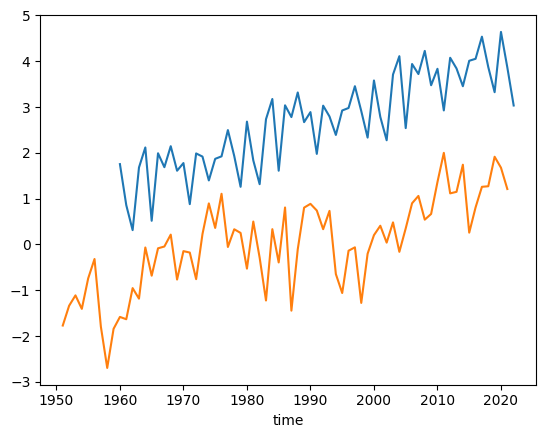

In [90]:
(S2_simulations['CLM5.0']/1e15).plot()
ds2.loc[1950:].shift(1).plot()

In [115]:
ds['time'] = (ds['time'].to_series() + pd.DateOffset(years=1)).values

In [70]:
S2_simulations

,CABLE-POP,CLASSIC,CLM5.0,DLEM,ED,ELM,ISAM,ISBA-CTRIP,JSBACH,JULES-ES,LPJ-GUESS,LPJml,OCNv2,ORCHIDEE-v3,SDGVM,LPJwsl,VISIT,YIBs,LPX-Bern
time,,,,,,,,,,,,,,,,,,,
1959,-2.801849e+14,NaN,NaN,4.345182e+14,7.110150e+14,1.106997e+15,1.448590e+15,9.656187e+14,3.945623e+14,-2.121851e+12,-7.087868e+14,3.924669e+13,9.650960e+14,5.450173e+14,2.048041e+14,-4.530509e+14,1.372114e+15,5.614263e+14,2.773347e+14
1960,2.139179e+15,1.058886e+15,1.754185e+15,1.671215e+15,1.142080e+15,2.218001e+15,1.319466e+15,9.976718e+14,2.161995e+15,6.367692e+14,8.361917e+14,1.601866e+15,1.130724e+15,1.174105e+15,4.067533e+14,3.433594e+14,1.551016e+15,1.486146e+15,6.450802e+14
1961,1.686051e+15,7.808008e+14,8.573601e+14,1.341876e+15,2.086029e+15,1.320250e+15,9.247182e+14,9.783638e+14,1.660198e+15,2.314966e+14,7.964967e+14,1.327644e+14,1.506684e+15,8.489907e+14,-7.040100e+14,-7.538327e+13,1.261610e+15,1.271409e+15,3.993475e+14
1962,1.830571e+15,9.534969e+14,3.122056e+14,1.855886e+15,1.718834e+15,1.544828e+15,1.437645e+15,1.179206e+15,2.182919e+15,1.713803e+15,1.425759e+15,1.115821e+15,1.744665e+15,1.531596e+15,-4.424598e+14,3.663320e+14,2.067068e+15,1.928362e+15,1.147866e+14
1963,1.405057e+15,-6.233050e+10,1.680173e+15,1.172225e+15,1.306013e+15,1.396852e+15,1.119441e+15,5.546877e+14,1.611221e+15,1.737913e+15,-2.604564e+13,3.492005e+14,1.600839e+15,7.598838e+14,7.545328e+14,-1.244012e+14,1.968654e+15,1.244499e+15,1.763546e+14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,2.738085e+15,2.633344e+15,3.324186e+15,2.946768e+15,5.763090e+15,2.405970e+15,3.036634e+15,2.464324e+15,4.386391e+15,2.499740e+15,3.132692e+15,2.521714e+15,4.207655e+15,1.799240e+15,2.664483e+15,3.411413e+15,3.099647e+15,3.775338e+15,1.222489e+15
2020,3.625759e+15,3.121892e+15,4.640821e+15,3.322229e+15,5.511924e+15,4.568930e+15,3.826876e+15,2.893369e+15,4.519080e+15,1.811213e+15,2.023128e+15,2.782878e+15,4.268352e+15,2.047234e+15,2.117428e+15,2.338940e+15,3.089554e+15,3.237399e+15,1.045602e+15
2021,4.453582e+15,3.772518e+15,3.865507e+15,4.172544e+15,5.896090e+15,5.111991e+15,3.407452e+15,4.109693e+15,4.195930e+15,2.373684e+15,2.860454e+15,3.042281e+15,4.069196e+15,2.952912e+15,2.688021e+15,2.502336e+15,4.369629e+15,3.890128e+15,1.384966e+15


In [51]:
((((S2_simulations/1e15).sub(GCB_global_results.iloc[:,2:-3],axis=0))**2).mean()**0.5).sort_values()


DLEM           2.858881e-10
ED             2.264264e-08
ISBA-CTRIP     2.499615e-07
LPJ-GUESS      2.942318e-03
YIBs           4.095069e-03
CABLE-POP      8.866147e-03
ORCHIDEE-v3    9.824279e-03
JSBACH         1.346642e-02
LPJwsl         2.484018e-02
SDGVM          3.352600e-02
CLM5.0         3.479730e-02
ISAM           3.761219e-02
CLASSIC        3.836437e-02
VISIT          4.066387e-02
LPX-Bern       4.678442e-02
LPJml          5.243951e-02
JULES-ES       6.256923e-02
OCNv2          7.813417e-02
ELM            4.129772e-01
IBIS                    NaN
dtype: float64